# FEBID Simulation optimization

### In this report two key improvements are described, that had the most significant impact on the code efficiency compared to the version discussed previously. Numexpr module was augumented with two new functions which allowed quicker expression processing. 'Ghost shell' maintence was optimized by utilizing Numpy's feature to use boolean arrays for indexing.

Current notebook uses a modified Numexpr module and thus has to be used from the project folder.

The following packages allow convenient time measurements and line-by-line profiling. Although, all the key results are dumped and presented, in order to run tests on a local amchine, it may be required to install packages by running cells below. 

It is suggested to run cells subsequently to avoid errors.

In [1]:
pip install timebudget

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install line_profiler

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
from numpy import asarray, zeros, copy, where, mgrid, s_
import scipy.constants as scpc
import math
import matplotlib.pyplot as plt
from matplotlib import cm
# from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv
from numexpr import evaluate
import numexpr
import cProfile
import warnings
import sys
from line_profiler import LineProfiler
from timebudget import timebudget

def plotit(grid):
    fig = plt.figure()
    ax = fig.add_subplot()
    im = ax.imshow(grid, cmap=plt.get_cmap('hot'), vmin=0, vmax=10 )
    ax.set_axis_off()
    fig.tight_layout()
    plt.show()

In [7]:
class Positionb:
    def __init__(self, z, y, x):
        self.x = x
        self.y = y
        self.z = z

# TODO: implement import of parameters from file
# <editor-fold desc="Parameters">
td = 1E-6  # dwell time of a beam, s
Ie = 1E-10  # beam current, A
beam_d = 10  # electron beam diameter, nm
effective_radius = beam_d * 3.3 # radius of an area which gets 99% of the electron beam
f = Ie / scpc.elementary_charge / (math.pi * beam_d * beam_d / 4)  # electron flux at the surface, 1/(nm^2*s)
F = 3000  # precursor flux at the surface, 1/(nm^2*s)   here assumed a constant, but may be dependent on time and position
tau = 500E-6  # average residence time, s; may be dependent on temperature

# Precursor properties
sigma = 2.2E-2  # dissociation cross section, nm^2 is averaged from cross sections of all electron types (PE,BSE, SE1, SE2)
n0 = 1.9  # inversed molecule size, Me3PtCpMe, 1/nm^2
M_Me3PtCpMe = 305  # molar mass of the precursor Me3Pt(IV)CpMe, g/mole
p_Me3PtCpMe = 1.5E-20  # density of the precursor Me3Pt(IV)CpMe, g/nm^3
V = 4 / 3 * math.pi * math.pow(0.139, 3)  # atomic volume of the deposited atom (Pt), nm^3
D = np.float32(1E5)  # diffusion coefficient, nm^2/s

###
dt = np.float32(1E-6)  # time step, s
# t = 2E-6  # absolute time, s

kd = F / n0 + 1 / tau + sigma * f  # depletion rate
kr = F / n0 + 1 / tau  # replenishment rate
nr = F / kr  # absolute density after long time
nd = F / kd  # depleted absolute density
t_out = 1 / (1 / tau + F / n0)  # effective residence time
p_out = 2 * math.sqrt(D * t_out) / beam_d
cell_dimension = 5  # side length of a square cell, nm
diffusion_dt = math.pow(cell_dimension * cell_dimension, 2) / (2 * D * (cell_dimension * cell_dimension + cell_dimension * cell_dimension))  # maximum stability lime of the diffusion solution
effective_radius_relative = math.floor(effective_radius/cell_dimension/2)
# </editor-fold>

# <editor-fold desc="Framework">
# Main cell matrixes.
# substrate[z,x,y] holds precursor density,
# deposit[z,y,x] holds deposit density.
system_size = 50
substrate = np.zeros((system_size, system_size, system_size), dtype=np.float32)
deposit = np.full((system_size, system_size, system_size),0 , dtype=np.float32)
substrate[0, :, :] = nr # filling substrate surface with initial precursor density
deposit[0, :, :] = 0.97
# deposit[0, 20:40, 20:40] = 0.95
zmax, ymax, xmax = substrate.shape # dimensions of the grid

# Holds z coordinates of the surface cells that are allowed to produce deposit.
# Indices of every cell correspond to their x&y position
# The idea is to avoid iterating through the whole 3D matrix and address only surface cells
# It is assumed, that surface cell is a cell with a fully deposited cell(or substrate) under it and thus able produce deposit under irradiation.
# Thus the number of surface cells is fixed.
# TODO: is it possible to create a non-contiguous and evolvable view to the 3D array? Later on all the surface should be able to produce deposit
surface = np.zeros((system_size, system_size), dtype=np.int16) # TODO: since lists allow sending a list of indices without a loop, surface matrix should be untilizing such data type for speed, but preserve addressability or quick search
surf =[] # a stub for holding a sequence of indices of surface cells for quick processing

ghost_zf, ghost_zb, ghost_yf, ghost_yb, ghost_xf, ghost_xb = set(), set(), set(), set(), set(), set()
# Sets where chosen for maintaining both semi-surface cells and ghost cells as they:
# 1. Doesn't require search to get an element — O(1)
# 2. Are faster than lists at adding/removing/getting values
# 3. Doesn't allow duplicates: if set already contains an item being added, effectively nothing happens
# 4. Have a convenient set().discard function, that quietly passes if an item is not in the set
ghosts = set() # all the ghost cells, that represent a closed shell of the surface to prevent diffusion into the void or back to deposit
val_zf, val_zb, val_yf, val_yb, val_xf, val_xb = [], [], [], [], [], [] # TODO clean up laplace_term_roll function and all corresponding variables

# Semi-surface cells are cells that have precursor density but do not have deposit right under them
# Thus they cannot produce deposit and their precursor density is calculated without disosisiation term.
# They are introduced to allow diffusion on the walls of the deposit.
semi_surface = set() # TODO: Numba doesn't really like sets (listed for deprication) –> Numpy arrays?
# TODO: maybe combine surface and semi-surface by utilizing subsets?
# </editor-fold>

a,b =[],[]
for i in range(50):
    for j in range(50):
        a.append(j)
        b.append(i)
stub = (np.asarray(b), np.asarray(a))

# @jit(nopython=True)
def pe_flux(r):
    """Calculates PE flux at the given radius according to Gaussian distribution.

    :param r: radius from the center of the beam.
    """
    #with timebudget("Flux time"):
    return f*math.exp(-r*r/(2*beam_d*beam_d))


# @jit(nopython=False, forceobj=True)
def make_tuple(arr): # TODO: make a quicker conversation
    """
    Converts an matrix array of z-indices(y=i, x=j) to a sequence of indices

    :param arr: array to convert
    :return: tuple(list[z], list[y], list[x]), indexing-ready
    """
    x,y,z =[],[],[]
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            x.append(j)
            y.append(i)
            z.append(arr[i,j])
    return [z, y , x]


# @jit(nopython=True, parallel=True)
def deposition(deposit, substrate, flux_matrix, surf, dt):
    """
    Calculates deposition on the surface for a given time step dt (outer loop).

    Instead of processing cell by cell and on the whole surface, it is implemented to process only (effectively) irradiated area and array-wise(thanks to Numpy)

    :param deposit: 3D deposit array
    :param substrate: 3D precursor density array
    :param flux_matrix: matrix of electron flux distribution
    :param surf: collection of surface cells indices (synchronized with th view)
    :param dt: time step
    :return: writes back to deposition array
    """
    #with timebudget("Deposition time"):
    deposit[surf]+=substrate[surf]*sigma*flux_matrix.view().reshape(flux_matrix.shape[0]**2)*V*dt


# @jit(nopython=True)
def update_surface(deposit, substrate, surface, surf, semi_surface, init_y=0, init_x=0):
    """
        Evolves surface upon a full deposition of a cell

    :param deposit: 3D deposit array
    :param substrate: 3D precursor density array
    :param surface: array corresponding to surface cells
    :param surf: collection of surface cells indices
    :param semi_surface: collection of semi-surface cells
    :param init_y: offset for y-axis
    :param init_x: offset for x-axis
    :return: changes surface array, semi-surface and ghosts collections
    """
    # because all arrays are sent to the function as views of the currently irradiated area (relative coordinate system), offsets are needed to update semi-surface and ghost cells collection, because they are stored in absolute coordinates
    new_deposits = np.argwhere(deposit>1)
    for cell in new_deposits:
        if deposit[cell[0], cell[1], cell[2]] >= 1:  # if the cell is fully deposited
            semi_surface.add((0, 0, 0))
            ghosts.add((cell[0], cell[1] + init_y, cell[2] + init_x))  # add fully deposited cell to the ghost shell
            surface[cell[1], cell[2]] +=1  # rising the surface one cell up (new cell)
            refresh(deposit, substrate, semi_surface, cell[0]+1, cell[1], cell[2], init_y, init_x)
    surf = make_tuple(surface)


def refresh(deposit, substrate, semi_surface, z,y,x, init_y=0, init_x=0):  # TODO: implement and include evolution of a ghost "shell" here, that should proceed along with the evolution of surface
    """
        Updates surface, semi-surface and ghost cells collections according to the provided coordinate of a fully deposited cell

    :param deposit: 3D deposit array
    :param substrate: 3D precursor density array
    :param semi_surface: collection of semi-surface cells
    :param z: z-coordinate of the cell above the new deposit
    :param y: y-coordinate of the deposit
    :param x: x-coordinate of the deposit
    :param init_y: offset for y-axis
    :param init_x: offset for x-axis
    :return: changes surface array, semi-surface and ghosts collections


    """
    semi_surface.discard((0,0,0))
    semi_surface.discard((z, y+init_y, x+init_x))  # removing the new cell from the semi_surface collection
    ghosts.discard((z, y + init_y, x + init_x)) # removing the new cell from the ghost shell collection
    deposit[z, y, x] = deposit[z - 1, y, x] - 1  # if the cell was fulled above unity, transferring that surplus to the cell above
    deposit[z - 1, y, x] = 1  # a fully deposited cell is always a unity
    xx = x + 2 # this is needed, due to the substrate view being 2 cells wider in case of semi-surface or ghost cell falling out of the bounds of the view
    yy = y + 2
    substrate[z, yy, xx] += substrate[z - 1, yy, xx] # if the deposited cell had precursor in it, transfer that surplus to the cell above
    substrate[z - 1, yy, xx] = 0  # precursor density is zero in the fully deposited cells
    if substrate[z+1, yy, xx] == 0: # if the cell above the new cell is empty, then add it to ghost shell collection
        ghosts.add((z+1, y+init_y, x+init_x))
    # Adding neighbors(in x-y plane) of the new cell to the semi_surface collection
    # and updating ghost shell for every neighbor:
    if substrate[z, yy - 1, xx] == 0:
        semi_surface.add((z, y - 1+init_y, x+init_x))  # adding cell to the list
        substrate[z, yy - 1, xx] += 1E-7 # "marks" cell as a surface one, because some of the checks refer to if the cell is empty. This assignment is essential
        refresh_ghosts(substrate, x + init_x, xx, y-1 + init_y, yy-1, z) # update ghost shell around
    if substrate[z, yy + 1, xx] == 0:
        semi_surface.add((z, y + 1+init_y, x+init_x))
        substrate[z, yy + 1, xx] += 1E-7
        refresh_ghosts(substrate, x + init_x, xx, y+1 + init_y, yy+1, z)
    if substrate[z, yy, xx - 1] == 0:
        semi_surface.add((z, y+init_y, x - 1+init_x))
        substrate[z, yy, xx - 1] += 1E-7
        refresh_ghosts(substrate, x -1 + init_x, xx-1, y + init_y, yy, z)
    if substrate[z, yy, xx + 1] == 0:
        semi_surface.add((z, y+init_y, x + 1+init_x))
        substrate[z, yy, xx + 1] += 1E-7
        refresh_ghosts(substrate, x + 1 + init_x, xx+1, y + init_y, yy, z)


def refresh_ghosts(substrate, x, xx, y, yy, z):
    """
    Updates ghost shell registry around the specified cell

    :param substrate: 3D precursor density array
    :param x: absolute x-coordinates of the cell
    :param xx: substrate view-relative x-coordinates of the cell
    :param y: absolute y-coordinates of the cell
    :param yy: substrate view-relative y-coordinates of the cell
    :param z: absolute z-coordinates of the cell
    :return: changes ghosts collection
    """
    # z-coordinates are same for both cases, because the view to a substrate is taken from the x-y plane
    global ghosts #TODO: send ghost shell collection as a parameter
    # First deleting current cell from ghost shell and then adding all neighboring cells(along all axis) if they are zero
    ghosts.discard((z, y, x))
    if substrate[z - 1, yy, xx] == 0:
        ghosts.add((z - 1, y, x))
    if substrate[z + 1, yy, xx] == 0:
        ghosts.add((z + 1, y, x))
    if substrate[z, yy - 1, xx] == 0:
        ghosts.add((z, y - 1, x))
    if substrate[z, yy + 1, xx] == 0:
        ghosts.add((z, y + 1, x))
    if substrate[z, yy, xx - 1] == 0:
        ghosts.add((z, y, x - 1))
    if substrate[z, yy, xx + 1] == 0:
        ghosts.add((z, y, x + 1))


def precursor_density(flux_matrix, substrate, dt):
    """
    Recalculates precursor density on the surface of the deposit

    :param flux_matrix: matrix of electron flux distribution
    :param substrate: 3D precursor density array
    :param dt: time step
    :return: changes substrate array
    """
    sub = np.zeros([ymax, xmax])  # surface cells array that will be processed to calculate a precursor density increment
    semi_sub = np.zeros((len(semi_surface))) # same for semi-surface cells
    sub[stub] = substrate[surface.flatten(), stub[0], stub[1]] # not using np.nditer speeded up the program by 10 times
    diffusion_matrix = laplace_term_rolling(substrate, D, dt)  # Diffusion term is calculated seperately and added in the end
    rk4(dt, sub, flux_matrix) # An increment is calculated through Runge-Kutta method without the diffusion term
    substrate[surface.flatten(), stub[0], stub[1]] += sub[stub]
    if any(semi_surface): # same process for semi-cells
        temp = list(zip(*semi_surface))
        temp = (np.asarray(temp[0]), np.asarray(temp[1]), np.asarray(temp[2]))
        semi_sub=substrate[temp]
        rk4(dt,semi_sub)
        substrate[temp]+=semi_sub
    substrate+=diffusion_matrix # finally adding diffusion term


# @jit(nopython=False, parallel=True)
# noinspection PyUnusedLocal
def rk4(dt, sub, flux_matrix=0):
    """
    Calculates increment of precursor density by Runge-Kutta method

    :param dt: time step
    :param sub: array of surface cells (2D for surface cells, 1D for semi-surface cells)
    :param flux_matrix: matrix of electron flux distribution
    :return: to sub array
    """
    k1 = precursor_density_increment(dt, sub, flux_matrix) # this is actually an array of k1 coefficients
    k2 = precursor_density_increment(dt/2, sub, flux_matrix, k1 / 2)
    k3 = precursor_density_increment(dt/2, sub, flux_matrix, k2 / 2)
    k4 = precursor_density_increment(dt, sub, flux_matrix, k3)
    numexpr.evaluate("(k1+k4)/6 +(k2+k3)/3", out=sub, casting='same_kind')


# @jit(nopython=False, parallel=True)
# noinspection PyUnusedLocal
def precursor_density_increment(dt, sub, flux_matrix, addon=0):
    """
    Calculates increment of the precursor density without a diffusion term

    :param dt: time step
    :param sub: array of surface cells (2D for surface cells, 1D dor semi-surface cells)
    :param flux_matrix: matrix of electron flux distribution
    :param addon: Runge Kutta term
    :return: to sub array
    """
    return numexpr.evaluate("(F * (1 - (sub + addon) / n0) - (sub + addon) / tau - (sub + addon) * sigma * flux_matrix)*dt")


def define_ghosts(substrate, surface, semi_surface =[] ): # TODO: find a mutable data structure(tuples are immutable), that would allow evolution of ghost cells "shell", rather than finding them every time. Such type must be quickly searchable or indexed and preferably not allow duplicates. Record class? Named tuples?
    """
    Defines ghost cells for every axis and direction separately.

    :param substrate: 3D precursor density array
    :param surface: surface cells matrix
    :param semi_surface: semi-surface cells list(set)
    :return: six lists with coordinates of ghost cells and six lists of corresponding values
    """
    xxf, xyf, xzf, yxf, yyf, yzf, zxf,zyf,zzf =[],[],[],[],[],[],[],[],[]
    xxb, xyb, xzb, yxb, yyb, yzb, zxb, zyb, zzb = [], [], [], [], [], [], [], [], []
    gxf, gxb, gyf, gyb, gzf, gzb = [],[],[],[],[],[]
    for y in range(surface.shape[0]):
        for x in range(surface.shape[1]):
            try:
                if substrate[surface[y,x]-1,y,x] == 0:
                    zxb.append(x)
                    zyb.append(y)
                    zzb.append(surface[y,x]-1)
                    gzb.append(substrate[surface[y,x], y,x])
            except IndexError:
                pass
            try:
                if substrate[surface[y,x]+1,y,x] == 0:
                    zxf.append(x)
                    zyf.append(y)
                    zzf.append(surface[y,x]+1)
                    gzf.append(substrate[surface[y,x], y,x])
            except IndexError:
                pass
            try:
                if substrate[surface[y,x],y-1,x] == 0:
                    yxb.append(x)
                    yyb.append(y-1)
                    yzb.append(surface[y,x])
                    gyb.append(substrate[surface[y,x], y,x])
            except IndexError:
                pass
            try:
                if substrate[surface[y,x],y+1,x] == 0:
                    yxf.append(x)
                    yyf.append(y+1)
                    yzf.append(surface[y,x])
                    gyf.append(substrate[surface[y,x], y,x])
            except IndexError:
                pass
            try:
                if substrate[surface[y,x],y,x-1] == 0:
                    xxb.append(x-1)
                    xyb.append(y)
                    xzb.append(surface[y,x])
                    gxb.append(substrate[surface[y,x], y,x])
            except IndexError:
                pass
            try:
                if substrate[surface[y,x],y,x+1] == 0:
                    xxf.append(x+1)
                    xyf.append(y)
                    xzf.append(surface[y,x])
                    gxf.append(substrate[surface[y,x], y,x])
            except IndexError:
                pass

    for cell in semi_surface:
        try:
            if substrate[cell[0]-1, cell[1], cell[2]] == 0:
                zzb.append(cell[0]-1)
                zyb.append(cell[1])
                zxb.append(cell[2])
                gzb.append(substrate[cell])
        except IndexError:
            pass
        try:
            if substrate[cell[0]+1, cell[1], cell[2]] == 0:
                zzf.append(cell[0]+1)
                zyf.append(cell[1])
                zxf.append(cell[2])
                gzf.append(substrate[cell])
        except IndexError:
            pass
        try:
            if substrate[cell[0], cell[1]-1, cell[2]] == 0:
                yzb.append(cell[0])
                yyb.append(cell[1]-1)
                yxb.append(cell[2])
                gyb.append(substrate[cell])
        except IndexError:
            pass
        try:
            if substrate[cell[0], cell[1]+1, cell[2]] == 0:
                yzf.append(cell[0])
                yyf.append(cell[1]+1)
                yxf.append(cell[2])
                gyf.append(substrate[cell])
        except IndexError:
            pass
        try:
            if substrate[cell[0], cell[1], cell[2]-1] == 0:
                xzb.append(cell[0])
                xyb.append(cell[1])
                xxb.append(cell[2]+1)
                gxb.append(substrate[cell])
        except IndexError:
            pass
        try:
            if substrate[cell[0], cell[1], cell[2]+1] == 0:
                xzf.append(cell[0])
                xyf.append(cell[1])
                xxf.append(cell[2]+1)
                gxf.append(substrate[cell])
        except IndexError:
            pass

    return [zzf, zyf, zxf], [zzb, zyb, zxb], [yzf, yyf, yxf], [yzb, yyb, yxb], [xzf, xyf, xxf], [xzb, xyb, xxb], gzf, gzb, gyf, gyb, gxf, gxb


def laplace_term_rolling(grid, D,  dt):
    """
    Calculates diffusion term for all surface cells using rolling

    :param grid: 3D precursor density array
    :param D: diffusion coefficient
    :param dt: time step
    :return: to grid array
    """
    grid_out = np.copy(grid)
    grid_out *= -6
    temp = list(zip(*ghosts)) # casting a set of coordinates to a list of index sequences for every dimension
    ghosts_index = (np.asarray(temp[0]), np.asarray(temp[1]), np.asarray(temp[2])) # constructing a tuple of ndarray sequences
    # X axis:
    # No need to have a separate array of values, when whe can conveniently call them from the origin:
    grid[ghosts_index] = grid[ghosts_index[0], ghosts_index[1], ghosts_index[2]-1] # assinging precursor density values to ghost cells along the rolling axis and direction
    grid_out[:,:, :-1]+=grid[:,:, 1:] #rolling forward
    grid_out[:,:,-1] += grid[:,:,-1] #taking care of edge values
    grid[ghosts_index] = 0 # flushing ghost cells
    # While Numpy allows negative indicies, indicies that are greater than the given dimention cause IndexiError and thus has to be taken care of
    temp = np.where(ghosts_index[2] > system_size - 2, ghosts_index[2] - 1, ghosts_index[2]) # decreasing all the edge indices by one to exclude falling out of the array
    grid[ghosts_index] = grid[ghosts_index[0], ghosts_index[1], temp+1]
    grid_out[:,:,1:] += grid[:,:,:-1] #rolling backwards
    grid_out[:, :, 0] += grid[:, :, 0]
    grid[ghosts_index] = 0
    # Y axis:
    grid[ghosts_index] = grid[ghosts_index[0], ghosts_index[1]-1, ghosts_index[2]]
    grid_out[:, :-1, :] += grid[:, 1:, :]
    grid_out[:, -1, :] += grid[:, -1, :]
    grid[ghosts_index] = 0
    temp = np.where(ghosts_index[1] > system_size - 2, ghosts_index[1] - 1, ghosts_index[1])
    grid[ghosts_index] = grid[ghosts_index[0], temp+1, ghosts_index[2]]
    grid_out[:, 1:, :] += grid[:, :-1, :]
    grid_out[:, 0, :] += grid[:, 0, :]
    grid[ghosts_index] = 0
    # Z-axis:
    grid[ghosts_index] = grid[ghosts_index[0]-1, ghosts_index[1], ghosts_index[2]]
    grid_out[:-1, :, :] += grid[1:, :, :]
    grid_out[-1, :, :] += grid[-1, :, :]
    grid[ghosts_index] = 0
    temp = np.where(ghosts_index[0] > system_size - 2, ghosts_index[0] - 1, ghosts_index[0])
    grid[ghosts_index] = grid[temp+1, ghosts_index[1], ghosts_index[2]]
    grid_out[1:, :, :] += grid[:-1, :, :]
    grid_out[0, :, :] += grid[0, :, :]
    grid[ghosts_index] = 0
    grid_out[ghosts_index]=0 # result has to also be cleaned as it has redundant values

    return numexpr.evaluate("grid_out*dt*D", casting='same_kind')


# @jit(nopython=False, parallel=True)
# noinspection PyIncorrectDocstring
def flux_matrix(matrix, y1, y2, x1, x2):
    """
    Calculates a matrix with electron flux distribution

    :param matrix: output matrix
    :param y1: y2, x1 – x2 – boundaries of the effectively irradiated area
    :return: to matrix array
    """
    matrix[:,:]=0 # flushing previous values
    irradiated_area = matrix[y1:y2, x1:x2]
    # irradiated_area = np.zeros((7,7), dtype=int)
    center = irradiated_area.shape[0]/2*cell_dimension # beam center in array-coordinates
    with np.nditer(irradiated_area, flags=['multi_index'], op_flags=['readwrite']) as it:
        for x in it:
            r = pythagor(it.multi_index[0]*cell_dimension-center, it.multi_index[1]*cell_dimension-center)
            if r<effective_radius:
                x[...]=pe_flux(r)


# @jit(nopython=True)
def pythagor(a,b):
    return math.sqrt(a*a+b*b)


# @jit(nopython=True)
def define_irradiated_area(beam, effective_radius): # TODO: this function will have most of its math redundant if coordinates system will be switched to array-based
    """
    Defines boundaries of the effectively irradiated area

    :param beam: beam position
    :param effective_radius: a distance at which intensity is lower than 99% of the distribution
    :return: four values limiting an area in x-y plane
    """
    norm_y_start = 0
    norm_y_end = math.floor((beam.y + effective_radius) / cell_dimension)
    norm_x_start = 0
    norm_x_end = math.floor((beam.x + effective_radius) / cell_dimension)
    temp = math.ceil((beam.y - effective_radius) / cell_dimension)
    if temp > 0:
        norm_y_start = temp
    if norm_y_end > ymax:
        norm_y_end = ymax
    temp = math.ceil((beam.x - effective_radius) / cell_dimension)
    if temp > 0:
        norm_x_start = temp
    if norm_x_end > xmax:
        norm_x_end = xmax
    return  norm_y_start, norm_y_end, norm_x_start, norm_x_end


# @jit(nopython=True, parallel=True, cache=True)
def show_yeld(deposit, summ, summ1, res):
    summ1 = np.sum(deposit)
    res = summ1-summ
    return summ, summ1, res


# /The printing loop.
# @jit(nopython=True)
def printing(loops=1): # TODO: maybe it could be a good idea to switch to an array-based iteration, rather than absolute distances(dwell_step). Precicision will be lost, but complexity of the code and coordinates management will be greatly simplified
    """
    Performs FEBID printing process in a zig-zag manner given number of times

    :param loops: number of repetitions of the route
    :return: changes deposit and substrate arrays
    """
    warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
    warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
    t = 2E-5 # absolute time, s
    dwell_step = beam_d
    x_offset = 75  # offset on the X-axis on both sides
    y_offset = 75  # offset on the Y-axis on both sides
    x_limit = xmax * cell_dimension - x_offset
    y_limit = ymax * cell_dimension - y_offset
    beam = Positionb(0, y_offset, x_offset)  # coordinates of the beam
    beam_matrix = np.zeros((system_size,system_size), dtype=int) # matrix for electron beam flux distribution
    beam_exposure = np.zeros((system_size,system_size), dtype=int) # see usage in the loop
    summ1,summ, result=0,0,0
    refresh_dt = dt*2 # dt for precursor density recalculation
    global ghost_zf, ghost_zb, ghost_yf, ghost_yb, ghost_xf, ghost_xb, val_zf, val_zb, val_yf, val_yb, val_xf, val_xb, ghosts
    ghost_zf, ghost_zb, ghost_yf, ghost_yb, ghost_xf, ghost_xb, val_zf, val_zb, val_yf, val_yb, val_xf, val_xb = define_ghosts(substrate, surface)
    ghost_zf = set(zip(*ghost_zf))
    ghosts = set.copy(ghost_zf)
    ch=' '
    for l in range(loops):  # loop repeats, currently beam travels in a zig-zack manner (array indexing)
        # summ1, summ, result = show_yeld(deposit, summ, summ1,result)
        # print(f'Deposit yield:{result}  Loop:{l}')
        if l%3==0:
            ch='\\'
        if l%3==1:
            ch='/'
        if l%3==2:
            ch='-'
        print(f'Loop:{l}   {ch}', end='\r')
        for beam.y in np.arange(y_offset, y_limit, dwell_step):  # beam travel along Y-axis
            for beam.x in np.arange(x_offset, x_limit, dwell_step):  # beam travel alon X-axis
                norm_y_start, norm_y_end, norm_x_start, norm_x_end = define_irradiated_area(beam,effective_radius) # Determining the area around the beam that is effectively irradiated
                irradiated_area_2D=np.s_[norm_y_start:norm_y_end, norm_x_start:norm_x_end] # a slice of the selecting currently irradiated area
                irradiated_area_3D=np.s_[:surface.max()+3, norm_y_start:norm_y_end, norm_x_start:norm_x_end]
                flux_matrix(beam_matrix, norm_y_start, norm_y_end, norm_x_start, norm_x_end)
                beam_exposure += beam_matrix # accumulates beam exposure for precursor density if it is called with an interval bigger that dt
                surf = make_tuple(surface[irradiated_area_2D]) # getting an indexing-ready surface cells coordinates
                # section = substrate[:, 20, :]
                while True:
                    deposition(deposit[irradiated_area_3D], substrate[irradiated_area_3D], beam_matrix[irradiated_area_2D], surf, dt) # depositing on a selected area
                    update_surface(deposit[irradiated_area_3D], substrate[:surface.max()+3, norm_y_start-2:norm_y_end+2, norm_x_start-2:norm_x_end+2], surface[irradiated_area_2D], surf, semi_surface, norm_y_start, norm_x_start) # updating surface on a selected area
                    if t % refresh_dt < 1E-6:
                        precursor_density(beam_matrix, substrate[:surface.max()+3,:,:], refresh_dt) # TODO: add tracking of the deposit's highest point and send only a reduced view to avoid unecessary operations on empty volume
                        beam_exposure = 0 # flushing accumulated radiation
                    t += dt

                    if not t % td > 1E-6:
                        break

### The initial version of code is presented above. 

Commented below cProfiler function can be run and will print a detailed report on every function call. 

A condensed report is presented just below.


**Main simulation parameters:**
+ System size = 50x50x50 cells
+ Dwell step = 2 cells
+ Margins = 15 cells 
+ Loops = 250


In [8]:
# This is a default Python module. Does not require installation.
# cProfile.runctx('printing(250)',globals(),locals())

|Number of calls|Pure time(s)|Cumulative time(s)|Function name
-----:|-----|-----|----------     
50000|5,285|7,521|make_tuple
3175000|1,661|2,146|pe_flux
25000|5,395|5,573|deposition
25000|0,494|5,435|update_surface
809|0,045|0,081|refresh
925|0,03|0,033|refresh_ghosts
12500|3,097|57,545|precursor_density
24741|0,672|10,666|rk4
98964|0,315|8,657|precursor_density_increment
12500|27,45|42,991|laplace_term_rolling
25000|5,889|10,351|flux_matrix
3600000|1,742|2,315|pythagor
25000|0,886|0,954|define_irradiated_area
1|2,058|86,951|printing
136205|0,661|0,811|Numexpr(getContext
928176|0,516|0,516|Numexpr(getType
136205|1,414|2,964|Numexpr(getArguments
136205|6,071|11,009|Numexpr(evaluate_from_cache

--------
*Pure time* — time taken by the function itself without nested function calls

*Cumulative time* — time taken by function in total

<br></br>
# Numexpr

##### Here Numexpr times are cumulative from all the calls of `evaluate` function. So far it is the core computing function, so the first optimization step involved Numexpr.
##### Numexpr does a great work at calcualtions, but it has to deal with expressions that are input as strings. In our case, `evaluate` function has to analyse the expression every time upon call, while there are only a few different ones. To eliminate this bottleneck, `cache_expression` and `evaluate_from_cache` functions were added to the Numexpr module. 


#### *Numexpr* processes expressions in several steps that include internal expression compilation, getting varaible Names, Types, Values and injecting it into the core function.
#### `cache_expression` function implements steps that correspond to expression analysis, precompilation and getting variable Names and Types. The result is an expression object that can be used for straight variables' values collection and calculation.
#### `evaluate_from_cache` represents an adapted `evaluate` function with the main feature of taking an already precompiled expression. Basically, it gets the values of the variables and injects it into the core calulating function.

Functions are presented below for reference

In [9]:
def cache_expression(ex, signature=()):
    context = getContext({}, frame_depth=1)
    names,ex_uses_vml  = getExprNames(ex, context)
    compiled_ex = NumExpr(ex, signature, **context)
    return dict(ex=compiled_ex, argnames=names, kwargs=kwargs)

def evaluate_from_cache(cached_expr, out=None, casting='safe', order='K', local_dict=None):
    try:
        compiled_ex = cached_expr['ex']
    except KeyError:
        raise RuntimeError("not a valid evaluate() expression")
    argnames = cached_expr['argnames']
    args = getArguments(argnames, local_dict)
    kwargs = {'out': out, 'order': order, 'casting': casting,
              'ex_uses_vml': False}
    with evaluate_lock:
        return compiled_ex(*args, **kwargs)

Importing modified Numexpr module and preparing sample data ащк :

In [10]:
from modified_libaries.numexpr import evaluate_from_cache, cache_expression

%load_ext line_profiler
sub=np.full((50,50), 0.83)
flux_matrix = np.zeros((50,50))
flux_matrix[20:30, 20:30] = 500000

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


#### Run of the `precursor_density_increment` function with the default `evaluate`:

In [13]:
# Addon is an intermediate product for Runge-Kutta method
def precursor_density_increment_evaluate(dt, sub, flux_matrix, addon=0):
    for i in range(10000):
        evaluate("(F * (1 - (sub + addon) / n0) - (sub + addon) / tau - (sub + addon) * sigma * flux_matrix)*dt")

%lprun -f precursor_density_increment_evaluate precursor_density_increment_evaluate(1E-6,sub,flux_matrix)

Timer unit: 1e-06 s

Total time: 2.17001 s
File: <ipython-input-13-b14697669d26>
Function: precursor_density_increment_evaluate at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def precursor_density_increment_evaluate(dt, sub, flux_matrix, addon=0):
     3     10001      15543.0      1.6      0.7      for i in range(10000):
     4     10000    2154470.0    215.4     99.3          evaluate("(F * (1 - (sub + addon) / n0) - (sub + addon) / tau - (sub + addon) * sigma * flux_matrix)*dt")

#### Now cache the expression and run the function with`evaluate_from_cache`:

In [14]:
prec_dens_expr=cache_expression("(F * (1 - (sub + addon) / n0) - (sub + addon) / tau - (sub + addon) * sigma * flux_matrix)*dt",[('F', np.int64), ('addon', np.float64), ('dt', np.float64), ('flux_matrix', np.float64), ('n0', np.float64), ('sigma',np.float64), ('sub', np.float64), ('tau', np.float64)])


def precursor_density_increment_evaluate_from_expr(dt, sub, flux_matrix, addon=0):
    for i in range(10000):
        evaluate_from_cache(prec_dens_expr)
%lprun -f precursor_density_increment_evaluate_from_expr precursor_density_increment_evaluate_from_expr(1E-6,sub,flux_matrix)

Timer unit: 1e-06 s

Total time: 1.71971 s
File: <ipython-input-14-b61e8fd86abf>
Function: precursor_density_increment_evaluate_from_expr at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def precursor_density_increment_evaluate_from_expr(dt, sub, flux_matrix, addon=0):
     5     10001      16668.0      1.7      1.0      for i in range(10000):
     6     10000    1703044.0    170.3     99.0          evaluate_from_cache(prec_dens_expr)

#### The resulting single (Per Hit) call times are ~145 µs and ~92 µs, which shows computing time reduction by ~35%
#### Same results are achived for `laplace_term_rolling`, `rk4` and `pe_flux` expressions.

--------
--------
#### Furthermore, math was also simplified. The main point is to reduce the number of constants:

$dn = (F(1 - \frac{n}{n_0}) - \frac{n}{tau} - n*\sigma*flux)dt = Fdt - n(\frac{F*dt*tau+n_0*dt}{tau*n_0} + \sigma*dt * flux)$

                  |
                  V
$dn = a - n(b + c * flux)$

#### Test with the simplified expression:

In [15]:
prec_dens_expr=cache_expression("F_dt - (sub + addon) * (F_dt_n0_tau + sigma_dt * flux_matrix)", [('F_dt', np.float64), ('F_dt_n0_tau', np.float64), ('addon', np.float64), ('flux_matrix', np.float64), ('sigma_dt',np.float64), ('sub', np.float64)])

def precursor_density_increment_evaluate_from_expr(dt, sub, flux_matrix, addon=0):
    for i in range(10000):
        evaluate_from_cache(prec_dens_expr, local_dict={'F_dt':F*dt, 'F_dt_n0_tau': (F*dt*tau+n0*dt)/(tau*n0), 'addon':addon, 'flux_matrix':flux_matrix, 'sigma_dt':sigma*dt, 'sub':sub},)

In [16]:
%lprun -f precursor_density_increment_evaluate_from_expr precursor_density_increment_evaluate_from_expr(1E-6,sub,flux_matrix)

Timer unit: 1e-06 s

Total time: 1.48835 s
File: <ipython-input-15-0560875728fa>
Function: precursor_density_increment_evaluate_from_expr at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def precursor_density_increment_evaluate_from_expr(dt, sub, flux_matrix, addon=0):
     4     10001      16819.0      1.7      1.1      for i in range(10000):
     5     10000    1471531.0    147.2     98.9          evaluate_from_cache(prec_dens_expr, local_dict={'F_dt':F*dt, 'F_dt_n0_tau': (F*dt*tau+n0*dt)/(tau*n0), 'addon':addon, 'flux_matrix':flux_matrix, 'sigma_dt':sigma*dt, 'sub':sub},)

#### Comparing to the previous result (92 µs), current single function call(~50 µs) is reduced by further ~40% .

# Diffusion function

##### `laplace_term_rolling` function is so far the heaviest called function in FEBID simulation.

##### While rolling operations are relatively efficient, "ghost shell" maintence remained a bottleneck.

##### Sets were utilized for that purpose and are quite efficient to operate with. But they implied a conversion to an indexing format. Such an operation, on the other hand, was quite inefficient. 

$$set\{(z_1, y_1, x_1), (z_2, y_2, x_2)...(z_n, y_n, x_n)\}   <—>  tuple(array(z_1, z_2...z_n), array(y_1, y_2...y_n), array(x_1, x_2...x_n))$$

#### 
<div style="text-align: center; font-style: italic";> Conversion compared to rolling operation </div>
<div><style>
  table {margin-left: 0 !important;}
  table {float:left}
  table { text-align: left }
</style>
    
Per Hit| % Time | Line
---|----|---
355.8   |  25.0     |     `temp = list(zip(*ghosts_set))`   — conversion 
21.8   |   1.5      |    `ghosts_index = (np.asarray(temp[0]), np.asarray(temp[1]), np.asarray(temp[2]))`
| | 
| | 
38.3   |   2.7     |     `grid_out[:,:, :-1]+=grid[:,:, 1:]`   — rolling
####   
#### Current solution utilizes Numpy's feature to index arrays with boolean arrays:

In [18]:
a = np.arange(25).reshape(5, 5)
b= np.full((5,5),False,dtype=bool)
b[[2,1,1,1,2], [0,1,2,3,4]] = True
print("Initial array:\n\n",a,"\n")
print("Indexing array: \n\n",b,"\n")
a[b]=0
print("Assigning 0 to 'True' elements: \n\n",a)

Initial array:

 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]] 

Indexing array: 

 [[False False False False False]
 [False  True  True  True False]
 [ True False False False  True]
 [False False False False False]
 [False False False False False]] 

Assigning 0 to 'True' elements: 

 [[ 0  1  2  3  4]
 [ 5  0  0  0  9]
 [ 0 11 12 13  0]
 [15 16 17 18 19]
 [20 21 22 23 24]]


##### One of the advantages of such technique is a way to conveniently assign values to ghost shells
##### by rolling the boolean array itself: 

In [19]:
a[b]= a[np.roll(b,1, axis=0)]
print("Pulling values up to empty cells:\n")
print(a)

Pulling values up to empty cells:

[[ 0  1  2  3  4]
 [ 5 11 12 13  9]
 [15 11 12 13 19]
 [15 16 17 18 19]
 [20 21 22 23 24]]



------
#### Here is a test of `laplace_term_rolling` function with sets and boolean indexing

Preparing functions and creating sample data:

In [40]:
from modified_libaries.numexpr import evaluate_from_cache, cache_expression
laplace1=cache_expression("grid_out*dt_D", [('dt_D', np.float64), ('grid_out', np.float64)])

# A surface on a substrate with almost depleeted precursor density around the center
struct=np.zeros((50,50,50), dtype=np.float64)
# Surrounding it with ghost shell
ghosts=np.full((50,50,50), False, dtype=bool)
ghosts[0,:,:] = True
ghosts[0, 10:40, 10:40] = False
ghosts[1, 10:40, 10:40] = True
ghosts[0, 3:11, 39:47] = False
ghosts_ind=np.nonzero(ghosts) # this method is called implicitly when using boolean array as index
ghosts_set=set()
for k in np.argwhere(ghosts):
    ghosts_set.add((k[0],k[1],k[2]))

def laplace_term_rolling_boolean(grid, ghosts_bool, D, dt, add = 0):

    for i in range(loops):
        grid_out = copy(grid)
        grid_out *= -6

        # X axis:
        # No need to have a separate array of values, when whe can conveniently call them from the original data
        shore = grid[:, :, 1:]
        wave = grid[:, :, :-1]
        shore[ghosts_bool[:, :, 1:]] = wave[ghosts_bool[:, :, 1:]] # assigning values to ghost cells forward along X-axis
        grid_out[:,:, :-1]+=grid[:,:, 1:] #rolling forward (actually backwards)
        grid_out[:,:,-1] += grid[:,:,-1] #taking care of edge values
        grid[ghosts_bool] = 0 # flushing ghost cells
        # Doing the same, but in reverse
        shore = grid[:, :, :-1]
        wave = grid[:, :, 1:]
        shore[ghosts_bool[:, :, :-1]] = wave[ghosts_bool[:, :, :-1]]
        grid_out[:,:,1:] += grid[:,:,:-1] #rolling backwards
        grid_out[:, :, 0] += grid[:, :, 0]
        grid[ghosts_bool] = 0

        # Y axis:
        shore = grid[:, 1:, :]
        wave = grid[:, :-1, :]
        shore[ghosts_bool[:, 1:, :]] = wave[ghosts_bool[:, 1:, :]]
        grid_out[:, :-1, :] += grid[:, 1:, :]
        grid_out[:, -1, :] += grid[:, -1, :]
        grid[ghosts_bool] = 0
        shore = grid[:, :-1, :]
        wave = grid[:, 1:, :]
        shore[ghosts_bool[:, :-1, :]] = wave[ghosts_bool[:, :-1, :]]
        grid_out[:, 1:, :] += grid[:, :-1, :]
        grid_out[:, 0, :] += grid[:, 0, :]
        grid[ghosts_bool] = 0

        # Z axis:
        shore = grid[1:, :, :]
        wave = grid[:-1, :, :]
        shore[ghosts_bool[1:, :, :]] = wave[ghosts_bool[1:, :, :]]
        grid_out[:-1, :, :] += grid[1:, :, :]
        grid_out[-1, :, :] += grid[-1, :, :]
        grid[ghosts_bool] = 0
        shore = grid[:-1, :, :]
        wave = grid[1:, :, :]
        shore[ghosts_bool[:-1, :, :]] = wave[ghosts_bool[:-1, :, :]]
        grid_out[1:, :, :] += grid[:-1, :, :]
        grid_out[0, :, :] += grid[0, :, :]
        grid[ghosts_bool] = 0
        grid_out[ghosts_bool]=0 # result also has to be cleaned as it contains redundant values in ghost cells
        grid += evaluate_from_cache(laplace1, local_dict={'dt_D': dt*D, 'grid_out':grid_out}, casting='same_kind')
    
    
def laplace_term_rolling(grid, ghosts_index, D, dt , add = 0):

    for i in range(loops):
        grid_out = copy(grid)
        grid_out *= -6
#         temp = list(zip(*ghosts_set)) # casting a set of coordinates to a list of index sequences for every dimension
#         ghosts_index = (np.asarray(temp[0]), np.asarray(temp[1]), np.asarray(temp[2])) # constructing a tuple of ndarray sequences
        # X axis:
        # No need to have a separate array of values, when whe can conveniently call them from the origin:
        grid[ghosts_index] = grid[ghosts_index[0], ghosts_index[1], ghosts_index[2]-1] # assinging precursor density values to ghost cells along the rolling axis and direction
        grid_out[:,:, :-1]+=grid[:,:, 1:] #rolling forward
        grid_out[:,:,-1] += grid[:,:,-1] #taking care of edge values
        grid[ghosts_index] = 0 # flushing ghost cells
        # While Numpy allows negative indicies, indicies that are greater than the given dimention cause IndexiError and thus has to be taken care of
        temp = where(ghosts_index[2] > 48, ghosts_index[2] - 1, ghosts_index[2]) # decreasing all the edge indices by one to exclude falling out of the array
        grid[ghosts_index] = grid[ghosts_index[0], ghosts_index[1], temp+1]
        grid_out[:,:,1:] += grid[:,:,:-1] #rolling backwards
        grid_out[:, :, 0] += grid[:, :, 0]
        grid[ghosts_index] = 0
        # Y axis:
        grid[ghosts_index] = grid[ghosts_index[0], ghosts_index[1]-1, ghosts_index[2]]
        grid_out[:, :-1, :] += grid[:, 1:, :]
        grid_out[:, -1, :] += grid[:, -1, :]
        grid[ghosts_index] = 0
        temp = where(ghosts_index[1] > 48, ghosts_index[1] - 1, ghosts_index[1])
        grid[ghosts_index] = grid[ghosts_index[0], temp+1, ghosts_index[2]]
        grid_out[:, 1:, :] += grid[:, :-1, :]
        grid_out[:, 0, :] += grid[:, 0, :]
        grid[ghosts_index] = 0
        # Z-axis:
        grid[ghosts_index] = grid[ghosts_index[0]-1, ghosts_index[1], ghosts_index[2]]
        grid_out[:-1, :, :] += grid[1:, :, :]
        grid_out[-1, :, :] += grid[-1, :, :]
        grid[ghosts_index] = 0
        temp = where(ghosts_index[0] > 48, ghosts_index[0] - 1, ghosts_index[0])
        grid[ghosts_index] = grid[temp+1, ghosts_index[1], ghosts_index[2]]
        grid_out[1:, :, :] += grid[:-1, :, :]
        grid_out[0, :, :] += grid[0, :, :]
        grid[ghosts_index] = 0
        grid_out[ghosts_index]=0 # result has also to be cleaned as it has redundant values in ghost cells
        grid += evaluate_from_cache(laplace1, local_dict={'dt_D': dt*D, 'grid_out':grid_out}, casting='same_kind')


#### Fistly, call with the index generated from set:
Note: conversion operation is ommited in this test, as it has to be run only after deposition event. 

(may take several seconds to finish)


 Laplace_term_rolling: took 9.478sec


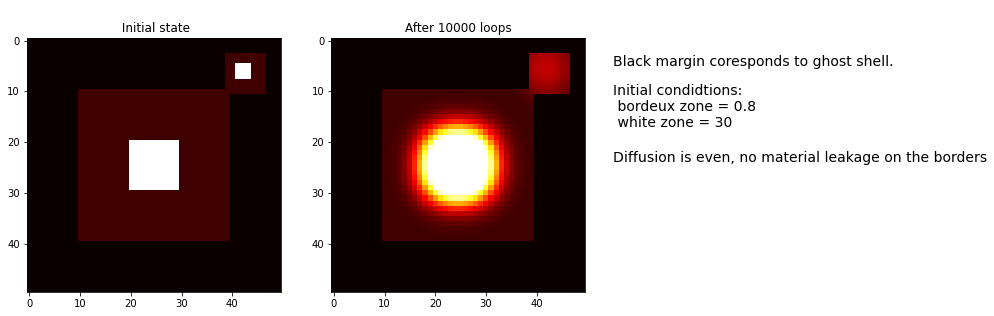

In [43]:
loops=10000
init_m=0.8
init_c=30
struct[0, 10:40, 10:40] = init_m
struct[0, 20:30, 20:30] = init_c
struct[0, 3:11, 39:47] = init_m
struct[0, 5:8, 41:44] = init_c


# plotit(struct[0,:,:])
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(121)
ax1.set_aspect(1)
ax1.set_title("\n Initial state")
ax1.imshow(struct[0,:,:], cmap=plt.get_cmap('hot'), vmin=0, vmax=10 )

with timebudget('\n Laplace_term_rolling:'):
    laplace_term_rolling(struct[0:3,:,:],ghosts_ind,500, 1E-6)
# To peek inside the function and check line-by-line timings, run the following line:
# %lprun -f laplace_term_rolling laplace_term_rolling(struct[0:3,:,:],ghosts_ind,1000, 1E-6)

ax2 = plt.subplot(122)
ax2.set_title(f'After {loops} loops')
ax2.imshow(struct[0,:,:], cmap=plt.get_cmap('hot'), vmin=0, vmax=10 )
plt.text(55,5, "Black margin coresponds to ghost shell.", size=14)
plt.text(55,17, f'Initial condidtions: \n bordeux zone = {init_m} \n white zone = {init_c}', size=14)
plt.text(55,24, "Diffusion is even, no material leakage on the borders", size=14)
plt.show()

------
#### Run function with the boolean indexing:


 Laplace_term_rolling boolean: took 5.086sec


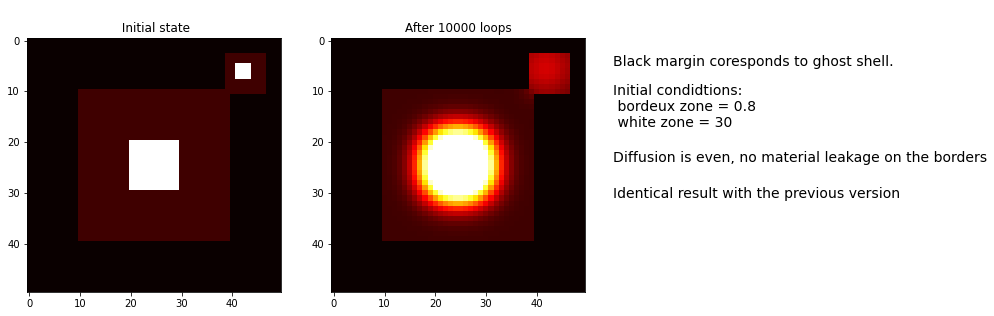

In [44]:
struct[0, 10:40, 10:40] = init_m
struct[0, 20:30, 20:30] = init_c
struct[0, 3:11, 39:47] = init_m
struct[0, 5:8, 41:44] = init_c

plt.figure(figsize=(10, 6))
ax1 = plt.subplot(121)
ax1.set_aspect(1)
ax1.set_title("\n Initial state")
ax1.imshow(struct[0,:,:], cmap=plt.get_cmap('hot'), vmin=0, vmax=10 )

with timebudget("\n Laplace_term_rolling boolean:"):
    laplace_term_rolling_boolean(struct[0:3,:,:],ghosts[0:3,:,:],500, 1E-6)
# To peek inside the function and check line-by-line timings, run the following line:
# %lprun -f laplace_term_rolling_boolean laplace_term_rolling_boolean(struct[0:3,:,:],ghosts[0:3,:,:],1000, 1E-6)

ax2 = plt.subplot(122)
ax2.set_title(f'After {loops} loops')
ax2.imshow(struct[0,:,:], cmap=plt.get_cmap('hot'), vmin=0, vmax=10 )
plt.text(55,5, "Black margin coresponds to ghost shell.", size=14)
plt.text(55,17, f'Initial condidtions: \n bordeux zone = {init_m} \n white zone = {init_c}', size=14)
plt.text(55,24, "Diffusion is even, no material leakage on the borders", size=14)
plt.text(55,31, "Identical result with the previous version", size=14)
plt.show()

#### Total times reveal that the script with boolean indexing is almost twice as fast as previous indexing technique with ~5 s against ~9 s. 

----
Boolean indexing was also introduced to surface and semi-surface cells maintence. This improvement is cumulative due to the growing number of semi-surface cells. Impact of the set() <-> tupleconversion operation on computing time would grow with the number of semi-surface cells. 

Overall results are presented in the end of this report.

### Array views

While `precursor_density` has to be run on the whole surface, `deposition` and `update_surafce` functions efficiently operate only on an irradiated(efficiently) area that is significantly smaller that the grid size. 
Selection of the area can be achieved by using views to an array by providing slices in array indexing: `grid[0:5, 15:30, 15:30]`. This optimization is rather minor, but is used as much as possible.
---
A simple example of such computing time reduction is presented below:

In [45]:
grid=np.zeros((50, 50, 50))

def flush_array(grid):
    for i in range(10000):
        grid[...]=0

with timebudget("Flashing whole array with zeros:"):
    flush_array(grid)
with timebudget("\nFlashing view of an array with zeros:"):
    flush_array(grid[0:4, 10:30, 10:30])

Flashing whole array with zeros: took 477.60ms

Flashing view of an array with zeros: took 13.59ms


In [46]:
# To peek inside the function and check single hit timings, the following lines can be run:
# %lprun -f flush_array flush_array(grid) 

In [47]:
# %lprun -f flush_array flush_array(grid[0:4, 10:20, 10:20])  

#### Function call times are ~450 ms and ~13 ms which is ~x30 speed-up
------

With other minor improvements, including:
+ Switching from absolute((x, y)nm) to realative(array[i, j]) coordiante system.
+ Calculating electron flux distribution as an array using `evaluate_from_cache`.
+ Depricating `make_tuple` function used to generate index for surface cells.
+ Minimizing the number of unnecessary function calls.

The resulting code is presented below:

In [ ]:
from modified_libaries.numexpr import evaluate_from_cache, cache_expression
# TODO: implement import of parameters from file
# <editor-fold desc="Parameters">
td = 1E-6  # dwell time of a beam, s
Ie = 1E-10  # beam current, A
beam_d = 10  # electron beam diameter, nm
effective_diameter = beam_d * 3.3 # radius of an area which gets 99% of the electron beam
f = Ie / scpc.elementary_charge / (math.pi * beam_d * beam_d / 4)  # electron flux at the surface, 1/(nm^2*s)
F = 3000  # precursor flux at the surface, 1/(nm^2*s)   here assumed a constant, but may be dependent on time and position
tau = 500E-6  # average residence time, s; may be dependent on temperature

# Precursor properties
sigma = 2.2E-2  # dissociation cross section, nm^2; is averaged from cross sections of all electron types (PE,BSE, SE1, SE2)
n0 = 1.9  # inversed molecule size, Me3PtCpMe, 1/nm^2
M_Me3PtCpMe = 305  # molar mass of the precursor Me3Pt(IV)CpMe, g/mole
p_Me3PtCpMe = 1.5E-20  # density of the precursor Me3Pt(IV)CpMe, g/nm^3
V = 4 / 3 * math.pi * math.pow(0.139, 3)  # atomic volume of the deposited atom (Pt), nm^3
D = np.float32(1E5)  # diffusion coefficient, nm^2/s


kd = F / n0 + 1 / tau + sigma * f  # depletion rate
kr = F / n0 + 1 / tau  # replenishment rate
nr = F / kr  # absolute density after long time
nd = F / kd  # depleted absolute density
t_out = 1 / (1 / tau + F / n0)  # effective residence time
p_out = 2 * math.sqrt(D * t_out) / beam_d
cell_dimension = 5  # side length of a square cell, nm

effective_radius_relative = math.floor(effective_diameter / cell_dimension / 2)

nn=1 # default number of threads for numexpr
# </editor-fold>

# <editor-fold desc="Timings">
dt = np.float32(1E-6)  # time step, s
t_flux = 1/(sigma+f)  # dissociation event time
diffusion_dt = math.pow(cell_dimension * cell_dimension, 2) / (2 * D * (cell_dimension * cell_dimension + cell_dimension * cell_dimension))   # maximum stability lime of the diffusion solution
tau = 500E-6  # average residence time, s; may be dependent on temperature
# </editor-fold>

# <editor-fold desc="Framework" >
# Main cell matrices
system_size = 50
height_multiplyer = 2
substrate = zeros((system_size*height_multiplyer, system_size, system_size), dtype=np.float32) # substrate[z,x,y] holds precursor density
deposit = zeros((system_size*height_multiplyer, system_size, system_size), dtype=np.float32) # deposit[z,y,x] holds deposit density
substrate[0, :, :] = nr  # filling substrate surface with initial precursor density
# deposit[0, 20:40, 20:40] = 0.95
zmax, ymax, xmax = substrate.shape # dimensions of the grid

# It is assumed, that surface cell is a cell with a fully deposited cell(or substrate) under it and thus able produce deposit under irradiation.
# The idea is to avoid iterating through the whole 3D matrix and address only surface cells
# Thus the number of surface cells is fixed.

# Semi-surface cells are cells that have precursor density but do not have deposit right under them
# Thus they cannot produce deposit and their precursor density is calculated without disosisiation term.
# They are introduced to allow diffusion on the walls of the deposit.
# Basically these are all other surface cells
# </editor-fold>

# <editor-fold desc="Helpers">
center = effective_radius_relative * cell_dimension  # beam center in array-coordinates
index_y, index_x = mgrid[0:(effective_radius_relative*2+1), 0:(effective_radius_relative*2+1)] # for indexing purposes of flux matrix
index_yy, index_xx = index_y*cell_dimension-center, index_x*cell_dimension-center

# A dictionary of expressions for numexpr.evaluate_from_cache
# Debug note: before introducing a new cached expression, that expression should be run with the default 'evaluate' function for fetching the signature list.
# This is required, because variables in it must be in the same order as Numexpr fetches them, otherwise Numexpr compiler will throw an error
expressions = dict(pe_flux=cache_expression("f*exp(-r*r/(2*beam_d*beam_d))", [('beam_d', np.int32), ('f', np.float64), ('r', np.float64)]),
                   rk4=cache_expression("(k1+k4)/6 +(k2+k3)/3", [('k1', np.float64), ('k2', np.float64), ('k3', np.float64), ('k4', np.float64)]),
                   #precursor_density_=cache_expression("(F * (1 - (sub + addon) / n0) - (sub + addon) / tau - (sub + addon) * sigma * flux_matrix)*dt", [('F', np.int64), ('addon', np.float64), ('dt', np.float64), ('flux_matrix', np.int64), ('n0', np.float64), ('sigma',np.float64), ('sub', np.float64), ('tau', np.float64)]),
                   precursor_density=cache_expression("F_dt - (sub + addon) * (F_dt_n0_1_tau_dt + sigma_dt * flux_matrix)", [('F_dt', np.float64), ('F_dt_n0_1_tau_dt', np.float64), ('addon', np.float64), ('flux_matrix', np.int64), ('sigma_dt',np.float64), ('sub', np.float64)]),
                   laplace1=cache_expression("grid_out*dt_D", [('dt_D', np.float64), ('grid_out', np.float64)]),
                   laplace2=cache_expression("grid_out*dt_D_div", [('dt_D_div', np.float64), ('grid_out', np.float64)]),
                   flux_matrix=cache_expression("((index_xx-center)*(index_xx-center)+(index_yy-center)*(index_yy-center))**0.5", [('center', np.int32), ('index_xx', np.int32), ('index_yy', np.int32)]))
# </editor-fold>

# @jit(nopython=True)
def pe_flux(r):
    """Calculates PE flux at the given radius according to Gaussian distribution.

    :param r: radius from the center of the beam.
    """
    # numexpr: no impact from number of cores or vml
    return evaluate_from_cache(expressions["pe_flux"])


# @jit(nopython=False, forceobj=True)
def make_tuple(arr):
    """
    DEPRICATED
    Converts a matrix array of z-indices(y=i, x=j) to a sequence of indices

    :param arr: array to convert
    :return: tuple(list[z], list[y], list[x]), indexing-ready
    """
    yy, xx = mgrid[0:arr.shape[0], 0:arr.shape[1]]
    return (arr.flatten(),yy.flatten(), xx.flatten())


# @jit(nopython=True)
def flush_structure(substrate: np.ndarray, deposit: np.ndarray, init_density: np.float32 = nr, init_deposit = .0, volume_prefill = .0):
    """
    Resets and prepares initial state of the printing framework

    :param substrate: 3D precursor density array
    :param deposit: 3D deposit array
    :param init_density: initial precursor density on the surface
    :param init_deposit: initial deposit on the surface, can be a 2D array with the same size as deposit array along 0 and 1 dimensions
    :param volume_prefill: initial deposit in the volume, can be a predefined structure in an 3D array same size as deposit array (constant value is virtual and used for code development)
    :return:
    """
    substrate[...] = 0
    substrate[0, :, :] = init_density  # filling substrate surface with initial precursor density
    if volume_prefill == 0:
        deposit[...] = 0
        if init_deposit != 0:
            deposit[0, :, :] = init_deposit # partially fills surface cells with deposit
    else:
        deposit[...] = volume_prefill # partially filling cells with deposit
        if init_deposit != 0:
            deposit[0, :, :] = init_deposit # partially fills surface cells with deposit


# @jit(nopython=True, parallel=True)
def deposition(deposit, substrate, flux_matrix, surface_bool, dt):

    """
    Calculates deposition on the surface for a given time step dt (outer loop)

    :param deposit: 3D deposit array
    :param substrate: 3D precursor density array
    :param flux_matrix: matrix of electron flux distribution
    :param dt: time step
    :return: writes back to deposit array
    """
    # Instead of processing cell by cell and on the whole surface, it is implemented to process only (effectively) irradiated area and array-wise(thanks to Numpy)
    # Math here cannot be efficiently simplified, because multiplication of constant variables here produces a value below np.float32 accuracy
    # np.float32 — ~1E-7, produced value — ~1E-10
    deposit[surface_bool] += substrate[surface_bool] * sigma * flux_matrix[surface_bool] * V * dt


# @jit(nopython=False)
def update_surface(deposit, substrate, surface_bool, semi_surf_bool, ghosts_bool, flux_matrix, z_max):
    """
    Evolves surface upon a full deposition of a cell. This method holds has the vast majority of logic

    :param deposit: 3D deposit array
    :param substrate: 3D precursor density array
    :param surface_bool: array representing surface cells
    :param semi_surf_bool: array representing semi-surface cells
    :param ghosts_bool: array representing ghost cells
    :param flux_matrix: matrix of electron flux distribution
    :param z_max: highest point along Z axis
    :return: changes surface, semi-surface and ghosts arrays
    """
    # Because all arrays are sent to the function as views of the currently irradiated area (relative coordinate system), offsets are required to update semi-surface and ghost cells collection, because they are stored in absolute coordinates
    new_deposits = np.argwhere(deposit>=1) # looking for new deposits
    if len(new_deposits) != 0:
        for cell in new_deposits:
            ghosts_bool[cell[0], cell[1]+2, cell[2]+2] = True # deposited cell belongs to ghost shell
            surface_bool[cell[0], cell[1], cell[2]] = False  # rising the surface one cell up (new cell)
            surface_bool[cell[0] + 1, cell[1], cell[2]] = True
            flux_matrix[cell[0]+1, cell[1], cell[2]] = flux_matrix[cell[0], cell[1], cell[2]] # flux_matrix shape must follow surface shape
            flux_matrix[cell[0], cell[1], cell[2]] = 0
            deposit[cell[0]+1, cell[1], cell[2]] += deposit[cell[0], cell[1], cell[2]] - 1  # if the cell was filled above unity, transferring that surplus to the cell above
            deposit[cell[0], cell[1], cell[2]] = -1  # a fully deposited cell is always a minus unity
            refresh(substrate, semi_surf_bool, ghosts_bool, cell[0] + 1, cell[1] + 2, cell[2] + 2)
        else:
            if cell[0] > z_max-4:
                z_max += 1
    return z_max


# @jit(nopython=True)
def refresh(substrate, semi_s_bool, ghosts_bool, z,y,x):
    """
    Updates surface, semi-surface and ghost cells collections according to the provided coordinate of a newly deposited cell

    :param substrate: 3D precursor density array
    :param semi_s_bool: array representing semi-surface cells
    :param ghosts_bool: array representing ghost cells
    :param z: z-coordinate of the cell above the new deposit
    :param y: y-coordinate of the deposit
    :param x: x-coordinate of the deposit
    :return: changes surface array, semi-surface and ghosts collections
    """
    # this is needed, due to the substrate view being 2 cells wider in case of semi-surface or ghost cell falling out of the bounds of the view
    semi_s_bool[z, y, x] = False # removing the new cell from the semi_surface collection
    ghosts_bool[z, y, x] = False # removing the new cell from the ghost shell collection
    substrate[z, y, x] += substrate[z - 1, y, x] # if the deposited cell had precursor in it, transfer that surplus to the cell above
    # this may lead to an overfilling of a cell above unity, but it is not causing any anomalies due to diffusion process
    substrate[z - 1, y, x] = np.nan  # precursor density is NaN in the fully deposited cells (it was previously set to zero, but later some of the zero cells were added back to semi-surface)
    if substrate[z+1, y, x] == 0: # if the cell that is above the new cell is empty, then add it to the ghost shell collection
        ghosts_bool[z+1, y, x] = True
    # Adding neighbors(in x-y plane) of the new cell to the semi_surface collection
    # and updating ghost shell for every neighbor:
    if substrate[z, y - 1, x] == 0:
        semi_s_bool[z, y - 1, x] = True
        substrate[z, y - 1, x] += 1E-7 # this "marks" cell as a surface one, because some of the checks refer to if the cell is empty. This assignment is essential. It corresponds to the smallest value that float32 can hold and should be changed corrspondingly to the variable type.
        refresh_ghosts(substrate, ghosts_bool, x, y-1, z) # update ghost shell around
    if substrate[z, y + 1, x] == 0:
        semi_s_bool[z, y + 1, x] = True
        substrate[z, y + 1, x] += 1E-7
        refresh_ghosts(substrate, ghosts_bool,  x, y+1, z)
    if substrate[z, y, x - 1] == 0:
        semi_s_bool[z, y, x - 1] = True
        substrate[z, y, x - 1] += 1E-7
        refresh_ghosts(substrate, ghosts_bool, x-1, y, z)
    if substrate[z, y, x + 1] == 0:
        semi_s_bool[z, y, x + 1] = True
        substrate[z, y, x + 1] += 1E-7
        refresh_ghosts(substrate, ghosts_bool, x+1, y, z)

        
# @jit(nopython=True)
def refresh_ghosts(substrate, ghosts_bool, x, y, z):
    """
    Updates ghost cells collection around the specified cell

    :param substrate: 3D precursor density array
    :param ghosts_bool: array representing ghost cells
    :param x: x-coordinates of the cell
    :param y: y-coordinates of the cell
    :param z: z-coordinates of the cell
    :return: changes ghosts array
    """
    # It must be kept in mind, that z-coordinate here is absolute, but x and y are relative to the view
    # Firstly, deleting current cell from ghost shell and then adding all neighboring cells(along all axis) if they are zero
    ghosts_bool[z, y, x] = False
    if substrate[z - 1, y, x] == 0:
        ghosts_bool[z - 1, y, x] = True
    if substrate[z + 1, y, x] == 0:
        ghosts_bool[z + 1, y, x] = True
    if substrate[z, y - 1, x] == 0:
        ghosts_bool[z, y - 1, x] = True
    if substrate[z, y + 1, x] == 0:
        ghosts_bool[z, y + 1, x] = True
    if substrate[z, y, x - 1] == 0:
        ghosts_bool[z, y, x - 1] = True
    if substrate[z, y, x + 1] == 0:
        ghosts_bool[z, y, x + 1] = True


# @profile
def precursor_density(flux_matrix, substrate, surface_bool, semi_surf_bool, ghosts_bool, dt):
    """
    Recalculates precursor density on the whole surface

    :param flux_matrix: matrix of electron flux distribution
    :param substrate: 3D precursor density array
    :param surface_bool: array representing surface cells
    :param semi_surf_bool: array representing semi-surface cells
    :param ghosts_bool: array representing ghost cells
    :param dt: time step
    :return: changes substrate array
    """
    diffusion_matrix = laplace_term_rolling(substrate, ghosts_bool, D, dt)  # Diffusion term is calculated separately and added in the end
    substrate[surface_bool] += rk4(dt, substrate[surface_bool], flux_matrix[surface_bool]) # An increment is calculated through Runge-Kutta method without the diffusion term
    substrate[semi_surf_bool] += rk4(dt, substrate[semi_surf_bool])  # same process for semi-cells, but without dissociation term
    substrate+=diffusion_matrix # finally adding diffusion term


# @jit(nopython=False, parallel=True)
# noinspection PyUnusedLocal
def rk4(dt, sub, flux_matrix=0):
    """
    Calculates increment of precursor density by Runge-Kutta method

    :param dt: time step
    :param sub: array of surface cells
    :param flux_matrix: matrix of electron flux distribution
    :return:
    """
    k1 = precursor_density_increment(dt, sub, flux_matrix) # this is actually an array of k1 coefficients
    k2 = precursor_density_increment(dt/2, sub, flux_matrix, k1 / 2)
    k3 = precursor_density_increment(dt/2, sub, flux_matrix, k2 / 2)
    k4 = precursor_density_increment(dt, sub, flux_matrix, k3)
    # numexpr: 1 core performs better
#     numexpr.set_num_threads(nn)
    return evaluate_from_cache(expressions["rk4"], casting='same_kind')


# @jit(nopython=False, parallel=True)
# noinspection PyUnusedLocal
def precursor_density_increment(dt, sub, flux_matrix, addon=0):
    """
    Calculates increment of the precursor density without a diffusion term

    :param dt: time step
    :param sub: array of surface cells (2D for surface cells, 1D dor semi-surface cells)
    :param flux_matrix: matrix of electron flux distribution
    :param addon: Runge Kutta term
    :return: to sub array
    """
    # numexpr: 1 core performs better
#     numexpr.set_num_threads(nn)
    return evaluate_from_cache(expressions["precursor_density"], local_dict={'F_dt':F*dt, 'F_dt_n0_1_tau_dt': (F*dt*tau+n0*dt)/(tau*n0), 'addon':addon, 'flux_matrix':flux_matrix, 'sigma_dt':sigma*dt, 'sub':sub}, casting='same_kind')


def rk4_diffusion(grid, ghosts_bool, D, dt):
    '''
    Calculates increment of the diffusion term

    :param grid: 3D array
    :param ghosts_bool: array representing ghost cells
    :param D: diffusion coefficient
    :param dt: time step
    :return: 3D array with the increments
    '''
    k1=laplace_term_rolling(grid, ghosts_bool, D, dt)
    k2=laplace_term_rolling(grid, ghosts_bool, D, dt, add=k1/2)
    k3=laplace_term_rolling(grid, ghosts_bool, D, dt, add=k2/2)
    k4=laplace_term_rolling(grid, ghosts_bool, D, dt, add=k3)
    numexpr.set_num_threads(nn)
    return evaluate_from_cache(expressions["rk4"], casting='same_kind')


# @jit(nopython=True, parallel=True, forceobj=False)
def laplace_term_rolling(grid, ghosts_bool, D, dt, add = 0, div: int = 0):
    """
    Calculates diffusion term for all surface cells using rolling


    :param grid: 3D precursor density array
    :param ghosts_bool: array representing ghost cells
    :param D: diffusion coefficient
    :param dt: time step
    :param add: Runge-Kutta intermediate member
    :param div:
    :return: to grid array
    """

    # Debugging note: it would be more elegant to just use numpy.roll() on the ghosts_bool to assign neighboring values
    # to ghost cells. But Numpy doesn't retain array structure when utilizing boolean index streaming. It rather extracts all the cells
    # (that correspond to True in our case) and processes them as a flat array. It caused the shifted values for ghost cells to
    # be assigned to the previous(first) layer, which was not processed by numpy.roll() when it rolled backwards.
    # Thus, borders(planes) that are not taking part in rolling(shifting) are cut off by using views to an array
    grid = grid + add
    grid_out = copy(grid)
    grid_out *= -6

    # X axis:
    # No need to have a separate array of values, when whe can conveniently call them from the original data
    shore = grid[:, :, 1:]
    wave = grid[:, :, :-1]
    shore[ghosts_bool[:, :, 1:]] = wave[ghosts_bool[:, :, 1:]] # assigning values to ghost cells forward along X-axis
    grid_out[:,:, :-1]+=grid[:,:, 1:] #rolling forward (actually backwards)
    grid_out[:,:,-1] += grid[:,:,-1] #taking care of edge values
    grid[ghosts_bool] = 0 # flushing ghost cells
    # Doing the same, but in reverse
    shore = grid[:, :, :-1]
    wave = grid[:, :, 1:]
    shore[ghosts_bool[:, :, :-1]] = wave[ghosts_bool[:, :, :-1]]
    grid_out[:,:,1:] += grid[:,:,:-1] #rolling backwards
    grid_out[:, :, 0] += grid[:, :, 0]
    grid[ghosts_bool] = 0

    # Y axis:
    shore = grid[:, 1:, :]
    wave = grid[:, :-1, :]
    shore[ghosts_bool[:, 1:, :]] = wave[ghosts_bool[:, 1:, :]]
    grid_out[:, :-1, :] += grid[:, 1:, :]
    grid_out[:, -1, :] += grid[:, -1, :]
    grid[ghosts_bool] = 0
    shore = grid[:, :-1, :]
    wave = grid[:, 1:, :]
    shore[ghosts_bool[:, :-1, :]] = wave[ghosts_bool[:, :-1, :]]
    grid_out[:, 1:, :] += grid[:, :-1, :]
    grid_out[:, 0, :] += grid[:, 0, :]
    grid[ghosts_bool] = 0

    # Z axis:
    shore = grid[1:, :, :]
    wave = grid[:-1, :, :]
    shore[ghosts_bool[1:, :, :]] = wave[ghosts_bool[1:, :, :]]
    grid_out[:-1, :, :] += grid[1:, :, :]
    grid_out[-1, :, :] += grid[-1, :, :]
    grid[ghosts_bool] = 0
    shore = grid[:-1, :, :]
    wave = grid[1:, :, :]
    shore[ghosts_bool[:-1, :, :]] = wave[ghosts_bool[:-1, :, :]]
    grid_out[1:, :, :] += grid[:-1, :, :]
    grid_out[0, :, :] += grid[0, :, :]
    grid[ghosts_bool] = 0
    grid_out[ghosts_bool]=0 # result also has to be cleaned as it contains redundant values in ghost cells
    # numexpr: 1 core performs better
    numexpr.set_num_threads(nn)
    if div == 0:
        return evaluate_from_cache(expressions["laplace1"], local_dict={'dt_D': dt*D, 'grid_out':grid_out}, casting='same_kind')


def define_ghosts(substrate, surface):
    """
    Defines ghost cells for every axis and direction separately.

    :param substrate: 3D precursor density array
    :param surface: surface cells matrix
    :return: six lists with coordinates of ghost cells and six lists of corresponding values
    """
    xxf, xyf, xzf, yxf, yyf, yzf, zxf,zyf,zzf =[],[],[],[],[],[],[],[],[]
    xxb, xyb, xzb, yxb, yyb, yzb, zxb, zyb, zzb = [], [], [], [], [], [], [], [], []
    gxf, gxb, gyf, gyb, gzf, gzb = [],[],[],[],[],[]
    for y in range(surface.shape[0]):
        for x in range(surface.shape[1]):
            try:
                if substrate[surface[y,x]-1,y,x] == 0:
                    zxb.append(x)
                    zyb.append(y)
                    zzb.append(surface[y,x]-1)
                    gzb.append(substrate[surface[y,x], y,x])
            except IndexError:
                pass
            try:
                if substrate[surface[y,x]+1,y,x] == 0:
                    zxf.append(x)
                    zyf.append(y)
                    zzf.append(surface[y,x]+1)
                    gzf.append(substrate[surface[y,x], y,x])
            except IndexError:
                pass
            try:
                if substrate[surface[y,x],y-1,x] == 0:
                    yxb.append(x)
                    yyb.append(y-1)
                    yzb.append(surface[y,x])
                    gyb.append(substrate[surface[y,x], y,x])
            except IndexError:
                pass
            try:
                if substrate[surface[y,x],y+1,x] == 0:
                    yxf.append(x)
                    yyf.append(y+1)
                    yzf.append(surface[y,x])
                    gyf.append(substrate[surface[y,x], y,x])
            except IndexError:
                pass
            try:
                if substrate[surface[y,x],y,x-1] == 0:
                    xxb.append(x-1)
                    xyb.append(y)
                    xzb.append(surface[y,x])
                    gxb.append(substrate[surface[y,x], y,x])
            except IndexError:
                pass
            try:
                if substrate[surface[y,x],y,x+1] == 0:
                    xxf.append(x+1)
                    xyf.append(y)
                    xzf.append(surface[y,x])
                    gxf.append(substrate[surface[y,x], y,x])
            except IndexError:
                pass

    return [zzf, zyf, zxf] # , [zzb, zyb, zxb], [yzf, yyf, yxf], [yzb, yyb, yxb], [xzf, xyf, xxf], [xzb, xyb, xxb], gzf, gzb, gyf, gyb, gxf, gxb


# @jit(nopython=False, parallel=True)
# noinspection PyIncorrectDocstring
def flux_matrix(matrix, surface_irradiated):
    """
    Calculates a matrix with electron flux distribution

    :param matrix: output matrix
    :param surface_irradiated: irradiated area
    :return: to matrix array
    """
    # TODO: with the same beam size, electron flux distribution is actually always the same, it just travels on the surface, thus no need to calculate it every time
    # TODO: distances from the center will always be the same, so the matrix of distances can be pre-calculated
    matrix[surface_irradiated] = pe_flux(np.hypot(index_xx, index_yy).reshape(-1))


# @jit(nopython=True)
def define_irradiated_area(y, x, effective_radius_relative:int):
    """
    Defines boundaries of the effectively irradiated area

    :param y: y-coordinate of the beam
    :param x: x-coordinate of the beam
    :param effective_radius_relative: a distance at which intensity is lower than 99% of the distribution
    :return: four values defining an area in x-y plane
    """
    norm_y_start = 0
    norm_y_end = y + effective_radius_relative
    norm_x_start = 0
    norm_x_end = x + effective_radius_relative
    temp = y - effective_radius_relative
    if temp > 0:
        norm_y_start = temp
    if norm_y_end > ymax:
        norm_y_end = ymax
    temp = x - effective_radius_relative
    if temp > 0:
        norm_x_start = temp
    if norm_x_end > xmax:
        norm_x_end = xmax
    return  norm_y_start, norm_y_end+1, norm_x_start, norm_x_end+1


# @jit(nopython=True, parallel=True, cache=True)
def show_yield(deposit, summ, summ1, res):
    summ1 = np.sum(deposit)
    res = summ1-summ
    return summ, summ1, res


# /The printing loop.
# @jit(nopython=True)
# @profile
def printing(loops=1):
    """
    Performs FEBID printing process in a zig-zag manner for given number of times

    :param loops: number of repetitions of the route
    :return: changes deposit and substrate arrays
    """
    warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
    warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

    # Prefill option
    flush_structure(substrate, deposit, init_deposit = 0.97, volume_prefill=0.0)

    ghosts = set(zip(*define_ghosts(substrate, zeros((system_size, system_size), dtype=int))))
    temp = tuple(zip(*ghosts))  # casting a set of coordinates to a list of index sequences for every dimension
    ghosts_index = (asarray(temp[0]), asarray(temp[1]), asarray(temp[2]))  # constructing a tuple of ndarray sequences
    ghosts_bool = np.full(substrate.shape, False, dtype=bool)
    ghosts_bool[ghosts_index]=True

    surface_bool = np.full((zmax, ymax, xmax), False, dtype=bool)
    surface_bool[0, :, :] = True # assumed that we have a flat substrate with no deposit

    semi_surface_bool = np.full((zmax, ymax, xmax), False, dtype=bool)

    t = 2E-6 # absolute time, s
    refresh_dt = dt*2 # dt for precursor density recalculation

    dwell_step = 2 # int(beam_d / 2/cell_dimension)
    x_offset = 15  # offset on the X-axis on both sides
    y_offset = 15  # offset on the Y-axis on both sides
    x_limit = xmax - x_offset
    y_limit = ymax - y_offset

    beam_matrix = zeros((zmax,ymax,xmax), dtype=int)  # matrix for electron beam flux distribution
    beam_exposure = zeros((zmax,ymax,xmax), dtype=int)  # see usage in the loop

    summ1,summ, result=0,0,0

    max_z=4 # used to track the highest point
    ext = 2 # a constant for inner update_surface logic
    ch=' '
    for l in range(loops):  # loop repeats, currently beam travels in a zig-zack manner (array indexing)
        # summ1, summ, result = show_yield(deposit, summ, summ1,result)
        # print(f'Deposit yield:{result}  Loop:{l}')
        if l%3==0:
            ch='\\'
        if l%3==1:
            ch='/'
        if l%3==2:
            ch='-'
        print(f'Loop:{l}   {ch}', end='\r')
        for y in range(y_offset, y_limit, dwell_step):  # beam travel along Y-axis
            for x in range(x_offset, x_limit, dwell_step):  # beam travel alon X-axis
                y_start, y_end, x_start, x_end = define_irradiated_area(y, x, effective_radius_relative) # Determining the area around the beam that is effectively irradiated
                # WARNING: there is no protection from falling out of an array!
                # There always must be at least 3 cells margin from irradiated area to array edges
                irradiated_area_3D=s_[:max_z, y_start:y_end, x_start:x_end] # a slice of the currently irradiated area
                irradiated_area_3D_ext = s_[:max_z, y_start-ext:y_end+ext, x_start-ext:x_end+ext]
                flux_matrix(beam_matrix[irradiated_area_3D], surface_bool[irradiated_area_3D]) # getting electron beam flux distribution matrix
                beam_exposure[irradiated_area_3D] += beam_matrix[irradiated_area_3D] # accumulates beam exposure for precursor density if it is called with an interval bigger that dt
                while True:
                    deposition(deposit[irradiated_area_3D],
                               substrate[irradiated_area_3D],
                               beam_matrix[irradiated_area_3D],
                               surface_bool[irradiated_area_3D], dt)  # depositing on a selected area
                    max_z = update_surface(deposit[irradiated_area_3D],
                                           substrate[irradiated_area_3D_ext],
                                           surface_bool[irradiated_area_3D],
                                           semi_surface_bool[irradiated_area_3D_ext],
                                           ghosts_bool[irradiated_area_3D_ext],
                                           beam_matrix[irradiated_area_3D],
                                           max_z)  # updating surface on a selected area
                    if t % refresh_dt < 1E-6:
                        precursor_density(beam_matrix[:max_z, :, :],
                                          substrate[:max_z, :, :],
                                          surface_bool[:max_z, :, :],
                                          semi_surface_bool[:max_z, :, :],
                                          ghosts_bool[:max_z, :, :], refresh_dt)
                        # if l==3:
                        #     profiler = line_profiler.LineProfiler()
                        #     profiled_func = profiler(precursor_density)
                        #     try:
                        #         profiled_func(beam_matrix, substrate[:surface.max()+3,:,:], surface, ghosts_index, refresh_dt)
                        #     finally:
                        #         profiler.print_stats()
                        beam_exposure[:max_z, y_offset-effective_radius_relative:y_limit+effective_radius_relative,x_offset-effective_radius_relative:x_limit+effective_radius_relative] = 0 # flushing accumulated radiation
                    t += dt

                    if not t % td > 1E-6:
                        break
                beam_matrix[irradiated_area_3D] = 0


To test how code runs on local machine, the following line can be run and a detailed report will be printed.

A condensed version with the comparison of computational times is presented below.

In [ ]:
# cProfile.runctx('printing(250)',globals(),locals())

<style>
  table {margin-left: 0 !important;}
  table {float:left}
  table { text-align: left }
</style>

                                 Older version: total time 86 s  |  New version:  total time 19 s.        
Num. of calls |Pure time(s) |Cumul. time(s) |Num. of calls |Pure time(s) |Cumul. time(s) |Func. Name | **Average improvement**
-----|-----|-----|----------|----| ----| ----- |------
50000|5,285|7,521|— |— |— |make_tuple|—
3175000|1,661|2,146|25000|0,045|0,741|pe_flux|**97%**
25000|5,395|5,573|25000|0,895|0,895|deposition|**83%**
25000|0,494|5,435|25000|0,364|1,387|update_surface|—
809|0,045|0,081|1694|0,068|0,123|refresh|—
925|0,03|0,033|1876|0,056|0,056|refresh_ghosts|—
12500|3,097|57,545|12500|1,744|14,48|precursor_density|**44%**
24741|0,672|10,666|25000|0,543|5,547|rk4|—
98964|0,315|8,657|100000|0,617|4,091|precursor_density_increment|—
12500|27,45|42,991|12500|6,525|7,188|laplace_term_rolling|**76%**
25000|5,889|10,351|25000|0,385|1,228|flux_matrix|**93%**
3600000|1,742|2,315|— |— |— |pythagor|—
25000|0,886|0,954|25000|0,035|0,035|define_irradiated_area|**96%**
1|2,058|86,951|1|1,029|19,186|printing|—
136205|0,661|0,811|— | —|— |Numexpr(getContext)|—
928176|0,516|0,516| —| —| —|Numexpr(getType)|—
136205|1,414|2,964|162500|1,029|2,307|Numexpr(getArguments)|**27%**
136205|6,071|11,009|162500|3,11|5,417|Numexpr(evaluate_from_cache)|**49%**

+ Described improvements allowed to speed up the code by more than 4 times.
+ From current perspective, further improvements may be achived by using Numba, parallelizing calculations and GPU.

### This concludes report
------
------
------

#### Appendix
To see under the hood in both versions of code all functions can be profiled seperately line by line by LineProfiler as it was shown in the examples.

In line `%lprun -f .......... printing(250)` insert a name of a desired function.

Profiler will show Total time used by the function, No. of hits, Total time, time per Hit and %Time time for every line.

In [ ]:
from line_profiler import LineProfiler
%load_ext line_profiler
#  substitute this function to the desired one
#          |
%lprun -f rk4 printing(250)
# 

### Deposited structure can be visualised using Ipyvolume:
To speed up deposition process, volume can be pre-filled. Check `flush_structure` call in the `printing` function.

In [48]:
z, y, x = np.nonzero(substrate)
c = substrate[z,y,x]
x = np.float64(x)
y = np.float64(y)
z = np.float64(z)
colormap = cm.plasma
color = colormap(c)
fig = ipv.figure(width=600)
ipv.zlim(0, (z.max()+10))
scatter = ipv.scatter(x, y, z, grow_limits=5, color=color, marker = 'box', size = 10)
ipv.view(0,-70)
ipv.show()